In [256]:
# Configuration - Set crop type and model variant here
crop_type = "corn"  # Change to "corn" or "soybean" as needed
weatherformer_variant = "weatherformersinusoid"  # Change to "weatherformer" or "weatherformersinusoid" as needed
model_display_name = 'VITA'  # Both weatherformer variants show as WeatherFormer

# Extreme years for each crop (used for cross-validation)
EXTREME_YEARS = {
    "corn": [2002, 2004, 2009, 2012, 2014],
    "soybean": [2003, 2004, 2009, 2012, 2016],
}

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Comprehensive rcParams for publication-ready neurips paper - SET ONCE
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 24,
    'axes.titlesize': 26,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 12,
    'lines.markeredgewidth': 2.5,
    'legend.frameon': False,
    'figure.dpi': 300,
    'font.weight': 'normal',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'grid.alpha': 0.3,
    'grid.linewidth': 1,
    'figure.figsize': (20, 6),
    'axes.grid': True,
})

print(f"Crop type set to: {crop_type}")
print(f"WeatherFormer variant set to: {weatherformer_variant}")


Crop type set to: corn
WeatherFormer variant set to: weatherformersinusoid


In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data using the crop_type and weatherformer_variant parameters
bert_data = pd.read_csv(f'data/grid_search_bert_pretrained_{crop_type}.tsv', sep='\t')
weatherformer_data = pd.read_csv(f'data/grid_search_{weatherformer_variant}_pretrained_{crop_type}.tsv', sep='\t')
simmtm_data = pd.read_csv(f'data/grid_search_simmtm_pretrained_{crop_type}.tsv', sep='\t')
gnnrnn_data = pd.read_csv(f'data/grid_search_gnnrnn_pretrained_{crop_type}.tsv', sep='\t')

# Extract R² values (removing ± error part)
bert_data['r2'] = bert_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
weatherformer_data['r2'] = weatherformer_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
simmtm_data['r2'] = simmtm_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
gnnrnn_data['r2'] = gnnrnn_data['year_15_r2'].str.split(' ± ').str[0].astype(float)

print("Data loaded successfully!")
print(f"BERT data shape: {bert_data.shape}")
print(f"WeatherFormer data shape: {weatherformer_data.shape}")
print(f"SimMTM data shape: {simmtm_data.shape}")
print(f"GNN-RNN data shape: {gnnrnn_data.shape}")

# Display first few rows
print("\nBERT data preview:")
print(bert_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nWeatherFormer data preview:")
print(weatherformer_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nSimMTM data preview:")
print(simmtm_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nGNN-RNN data preview:")
print(gnnrnn_data[['batch_size', 'init_lr', 'beta', 'r2']].head())


Data loaded successfully!
BERT data shape: (9, 8)
WeatherFormer data shape: (27, 8)
SimMTM data shape: (9, 8)
GNN-RNN data shape: (9, 8)

BERT data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.639
1          16  0.00050   0.0  0.642
2          16  0.00100   0.0  0.648
3          32  0.00025   0.0  0.644
4          32  0.00050   0.0  0.673

WeatherFormer data preview:
   batch_size  init_lr    beta     r2
0          16  0.00025  0.0000  0.708
1          16  0.00025  0.0001  0.711
2          16  0.00025  0.0010  0.704
3          16  0.00050  0.0000  0.699
4          16  0.00050  0.0001  0.721

SimMTM data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.643
1          16  0.00050   0.0  0.627
2          16  0.00100   0.0  0.569
3          32  0.00025   0.0  0.664
4          32  0.00050   0.0  0.588

GNN-RNN data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.556
1          16  0.00050   0.0  0.575
2

In [258]:
# Prepare data for each subplot

# 1. Batch size vs R² (best R² for each batch size per model)
batch_sizes = [16, 32, 64]
batch_bert_r2 = []
batch_weatherformer_r2 = []
batch_simmtm_r2 = []
batch_gnnrnn_r2 = []

for bs in batch_sizes:
    # BERT: best R² for this batch size
    bert_best = bert_data[bert_data['batch_size'] == bs]['r2'].max()
    batch_bert_r2.append(bert_best)
    
    # WeatherFormer: best R² for this batch size (across all betas)
    wf_best = weatherformer_data[weatherformer_data['batch_size'] == bs]['r2'].max()
    batch_weatherformer_r2.append(wf_best)
    
    # SimMTM: best R² for this batch size
    simmtm_best = simmtm_data[simmtm_data['batch_size'] == bs]['r2'].max()
    batch_simmtm_r2.append(simmtm_best)
    
    # GNN-RNN: best R² for this batch size
    gnnrnn_best = gnnrnn_data[gnnrnn_data['batch_size'] == bs]['r2'].max()
    batch_gnnrnn_r2.append(gnnrnn_best)

# 2. Learning rate vs R² (best R² for each learning rate per model)
learning_rates = [0.00025, 0.0005, 0.001]
lr_bert_r2 = []
lr_weatherformer_r2 = []
lr_simmtm_r2 = []
lr_gnnrnn_r2 = []

for lr in learning_rates:
    # BERT: best R² for this learning rate
    bert_best = bert_data[bert_data['init_lr'] == lr]['r2'].max()
    lr_bert_r2.append(bert_best)
    
    # WeatherFormer: best R² for this learning rate (across all betas)
    wf_best = weatherformer_data[weatherformer_data['init_lr'] == lr]['r2'].max()
    lr_weatherformer_r2.append(wf_best)
    
    # SimMTM: best R² for this learning rate
    simmtm_best = simmtm_data[simmtm_data['init_lr'] == lr]['r2'].max()
    lr_simmtm_r2.append(simmtm_best)
    
    # GNN-RNN: best R² for this learning rate
    gnnrnn_best = gnnrnn_data[gnnrnn_data['init_lr'] == lr]['r2'].max()
    lr_gnnrnn_r2.append(gnnrnn_best)

# 3. Beta vs R² (WeatherFormer only - GNN-RNN only has beta=0.0)
betas = [0.0, 0.0001, 0.001]
beta_weatherformer_r2 = []

for beta in betas:
    # WeatherFormer: best R² for this beta (across all other hyperparams)
    wf_best = weatherformer_data[weatherformer_data['beta'] == beta]['r2'].max()
    beta_weatherformer_r2.append(wf_best)

print("Data prepared for plotting:")
print(f"Batch sizes: {batch_sizes}")
print(f"BERT R² by batch size: {batch_bert_r2}")
print(f"WeatherFormer R² by batch size: {batch_weatherformer_r2}")
print(f"SimMTM R² by batch size: {batch_simmtm_r2}")
print(f"GNN-RNN R² by batch size: {batch_gnnrnn_r2}")
print(f"Learning rates: {learning_rates}")
print(f"BERT R² by learning rate: {lr_bert_r2}")
print(f"WeatherFormer R² by learning rate: {lr_weatherformer_r2}")
print(f"SimMTM R² by learning rate: {lr_simmtm_r2}")
print(f"GNN-RNN R² by learning rate: {lr_gnnrnn_r2}")
print(f"Betas: {betas}")
print(f"WeatherFormer R² by beta: {beta_weatherformer_r2}")


Data prepared for plotting:
Batch sizes: [16, 32, 64]
BERT R² by batch size: [0.648, 0.673, 0.662]
WeatherFormer R² by batch size: [0.721, 0.729, 0.723]
SimMTM R² by batch size: [0.643, 0.664, 0.66]
GNN-RNN R² by batch size: [0.575, 0.588, 0.512]
Learning rates: [0.00025, 0.0005, 0.001]
BERT R² by learning rate: [0.644, 0.673, 0.651]
WeatherFormer R² by learning rate: [0.719, 0.723, 0.729]
SimMTM R² by learning rate: [0.664, 0.649, 0.64]
GNN-RNN R² by learning rate: [0.556, 0.575, 0.588]
Betas: [0.0, 0.0001, 0.001]
WeatherFormer R² by beta: [0.729, 0.723, 0.704]


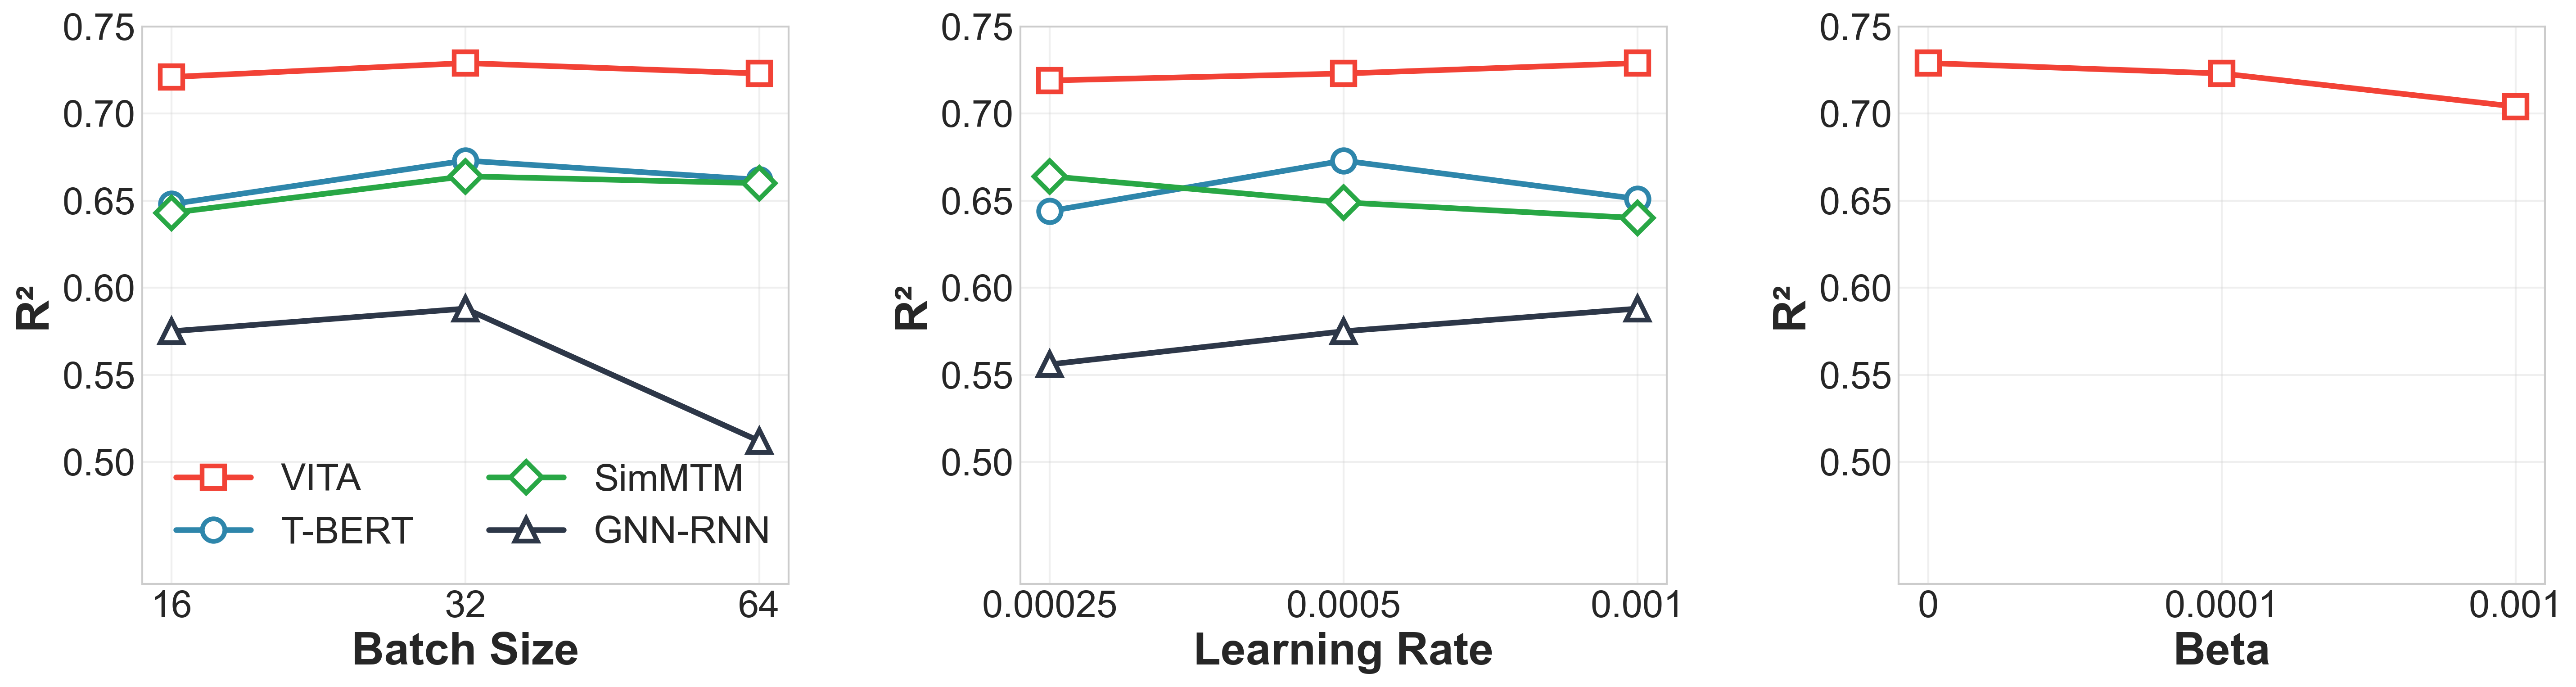

saved as '../data/latex/img/grid_search_corn.pdf'


In [259]:
# Create the professional neurips-style plot - all styling handled by rcParams
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Define colors and markers for models - performance order: VITA, BERT, SimMTM, GNN-RNN
colors = {model_display_name: '#F24236', 'BERT': '#2E86AB', 'SimMTM': '#28A745', 'GNN-RNN': '#2D3748'}
markers = {model_display_name: 's', 'BERT': 'o', 'SimMTM': 'D', 'GNN-RNN': '^'}

# Plot 1: Batch Size vs R² (legend only here) - performance order
x_batch = np.arange(len(batch_sizes))
ax1.plot(x_batch, batch_weatherformer_r2, color=colors[model_display_name], marker=markers[model_display_name], 
         label=model_display_name, markerfacecolor='white', markeredgecolor=colors[model_display_name])
ax1.plot(x_batch, batch_bert_r2, color=colors['BERT'], marker=markers['BERT'], 
         label='T-BERT', markerfacecolor='white', markeredgecolor=colors['BERT'])
ax1.plot(x_batch, batch_simmtm_r2, color=colors['SimMTM'], marker=markers['SimMTM'], 
         label='SimMTM', markerfacecolor='white', markeredgecolor=colors['SimMTM'])
ax1.plot(x_batch, batch_gnnrnn_r2, color=colors['GNN-RNN'], marker=markers['GNN-RNN'], 
         label='GNN-RNN', markerfacecolor='white', markeredgecolor=colors['GNN-RNN'])

ax1.set_xlabel('Batch Size')
ax1.set_ylabel('R²')
ax1.set_xticks(x_batch)
ax1.set_xticklabels(batch_sizes)
ax1.legend(loc='lower left', ncol=2)

# Plot 2: Learning Rate vs R² (no legend) - same order
x_lr = np.arange(len(learning_rates))
ax2.plot(x_lr, lr_weatherformer_r2, color=colors[model_display_name], marker=markers[model_display_name], 
         markerfacecolor='white', markeredgecolor=colors[model_display_name])
ax2.plot(x_lr, lr_bert_r2, color=colors['BERT'], marker=markers['BERT'], 
         markerfacecolor='white', markeredgecolor=colors['BERT'])
ax2.plot(x_lr, lr_simmtm_r2, color=colors['SimMTM'], marker=markers['SimMTM'], 
         markerfacecolor='white', markeredgecolor=colors['SimMTM'])
ax2.plot(x_lr, lr_gnnrnn_r2, color=colors['GNN-RNN'], marker=markers['GNN-RNN'], 
         markerfacecolor='white', markeredgecolor=colors['GNN-RNN'])

ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('R²')
ax2.set_xticks(x_lr)
ax2.set_xticklabels(['0.00025', '0.0005', '0.001'])

# Plot 3: Beta vs R² (WeatherFormer only, no legend)
x_beta = np.arange(len(betas))
ax3.plot(x_beta, beta_weatherformer_r2, color=colors[model_display_name], marker=markers[model_display_name], 
         markerfacecolor='white', markeredgecolor=colors[model_display_name])

ax3.set_xlabel('Beta')
ax3.set_ylabel('R²')
ax3.set_xticks(x_beta)
ax3.set_xticklabels(['0', '0.0001', '0.001'])


if crop_type == 'soybean':
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0.58, 0.75)
        ax.set_yticks([0.60, 0.65, 0.70, 0.75])

else:
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0.43, 0.75)
        ax.set_yticks([0.50, 0.55, 0.60, 0.65, 0.70, 0.75])

# Create output directory if it doesn't exist
import os
os.makedirs('../data/latex/img', exist_ok=True)

# Adjust layout and save
plt.tight_layout(pad=2.0)
plt.savefig(f'../data/latex/img/grid_search_{crop_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"saved as '../data/latex/img/grid_search_{crop_type}.pdf'")


In [260]:
import json

# Load JSON files for individual R² values
with open(f'data/grid_search_bert_pretrained_{crop_type}.json', 'r') as f:
    bert_json = json.load(f)

with open(f'data/grid_search_{weatherformer_variant}_pretrained_{crop_type}.json', 'r') as f:
    weatherformer_json = json.load(f)

with open(f'data/grid_search_simmtm_pretrained_{crop_type}.json', 'r') as f:
    simmtm_json = json.load(f)

with open(f'data/grid_search_gnnrnn_pretrained_{crop_type}.json', 'r') as f:
    gnnrnn_json = json.load(f)

# Find the best performing model for each type based on mean R²
best_bert_config = None
best_bert_r2 = -1
best_weatherformer_config = None
best_weatherformer_r2 = -1
best_simmtm_config = None
best_simmtm_r2 = -1

# Find best BERT configuration
for config_name, results in bert_json.items():
    mean_r2 = results['year_15']['mean_r2']
    if mean_r2 > best_bert_r2:
        best_bert_r2 = mean_r2
        best_bert_config = config_name

# Find best WeatherFormer configuration
for config_name, results in weatherformer_json.items():
    mean_r2 = results['year_15']['mean_r2']
    if mean_r2 > best_weatherformer_r2:
        best_weatherformer_r2 = mean_r2
        best_weatherformer_config = config_name

# Find best SimMTM configuration
for config_name, results in simmtm_json.items():
    mean_r2 = results['year_15']['mean_r2']
    if mean_r2 > best_simmtm_r2:
        best_simmtm_r2 = mean_r2
        best_simmtm_config = config_name

print(f"Best BERT configuration: {best_bert_config}")
print(f"Best BERT mean R²: {best_bert_r2:.3f}")
print(f"Best WeatherFormer configuration: {best_weatherformer_config}")
print(f"Best WeatherFormer mean R²: {best_weatherformer_r2:.3f}")
print(f"Best SimMTM configuration: {best_simmtm_config}")
print(f"Best SimMTM mean R²: {best_simmtm_r2:.3f}")

# Extract individual R² values for the best configurations
best_bert_individual_r2 = bert_json[best_bert_config]['year_15']['individual_r2_values']
best_weatherformer_individual_r2 = weatherformer_json[best_weatherformer_config]['year_15']['individual_r2_values']
best_simmtm_individual_r2 = simmtm_json[best_simmtm_config]['year_15']['individual_r2_values']

print(f"\nBest BERT individual R² values: {best_bert_individual_r2}")
print(f"Best WeatherFormer individual R² values: {best_weatherformer_individual_r2}")
print(f"Best SimMTM individual R² values: {best_simmtm_individual_r2}")


Best BERT configuration: bert_pretrained_corn_beta_0.0_bs_32_lr_0.0005
Best BERT mean R²: 0.673
Best WeatherFormer configuration: weatherformersinusoid_pretrained_corn_beta_0.0_bs_32_lr_0.001
Best WeatherFormer mean R²: 0.729
Best SimMTM configuration: simmtm_pretrained_corn_beta_0.0_bs_32_lr_0.00025
Best SimMTM mean R²: 0.664

Best BERT individual R² values: [0.6827081332460465, 0.6284219172100061, 0.8399455602360912, 0.43925697857108925, 0.7724379364617643]
Best WeatherFormer individual R² values: [0.7370907190119478, 0.7089895789334202, 0.8682148384774022, 0.5212034809588963, 0.8111434615372615]
Best SimMTM individual R² values: [0.6970436821893122, 0.6459221682341109, 0.8470356429259731, 0.3798783526958083, 0.7492656488689499]


In [261]:
# Increase legend, ticks, and axis labels by 50% for individual plot
plt.rcParams.update({
    'axes.labelsize': 36,      # 24 * 1.5
    'xtick.labelsize': 30,     # 20 * 1.5  
    'ytick.labelsize': 30,     # 20 * 1.5
    'legend.fontsize': 30,     # 20 * 1.5
})


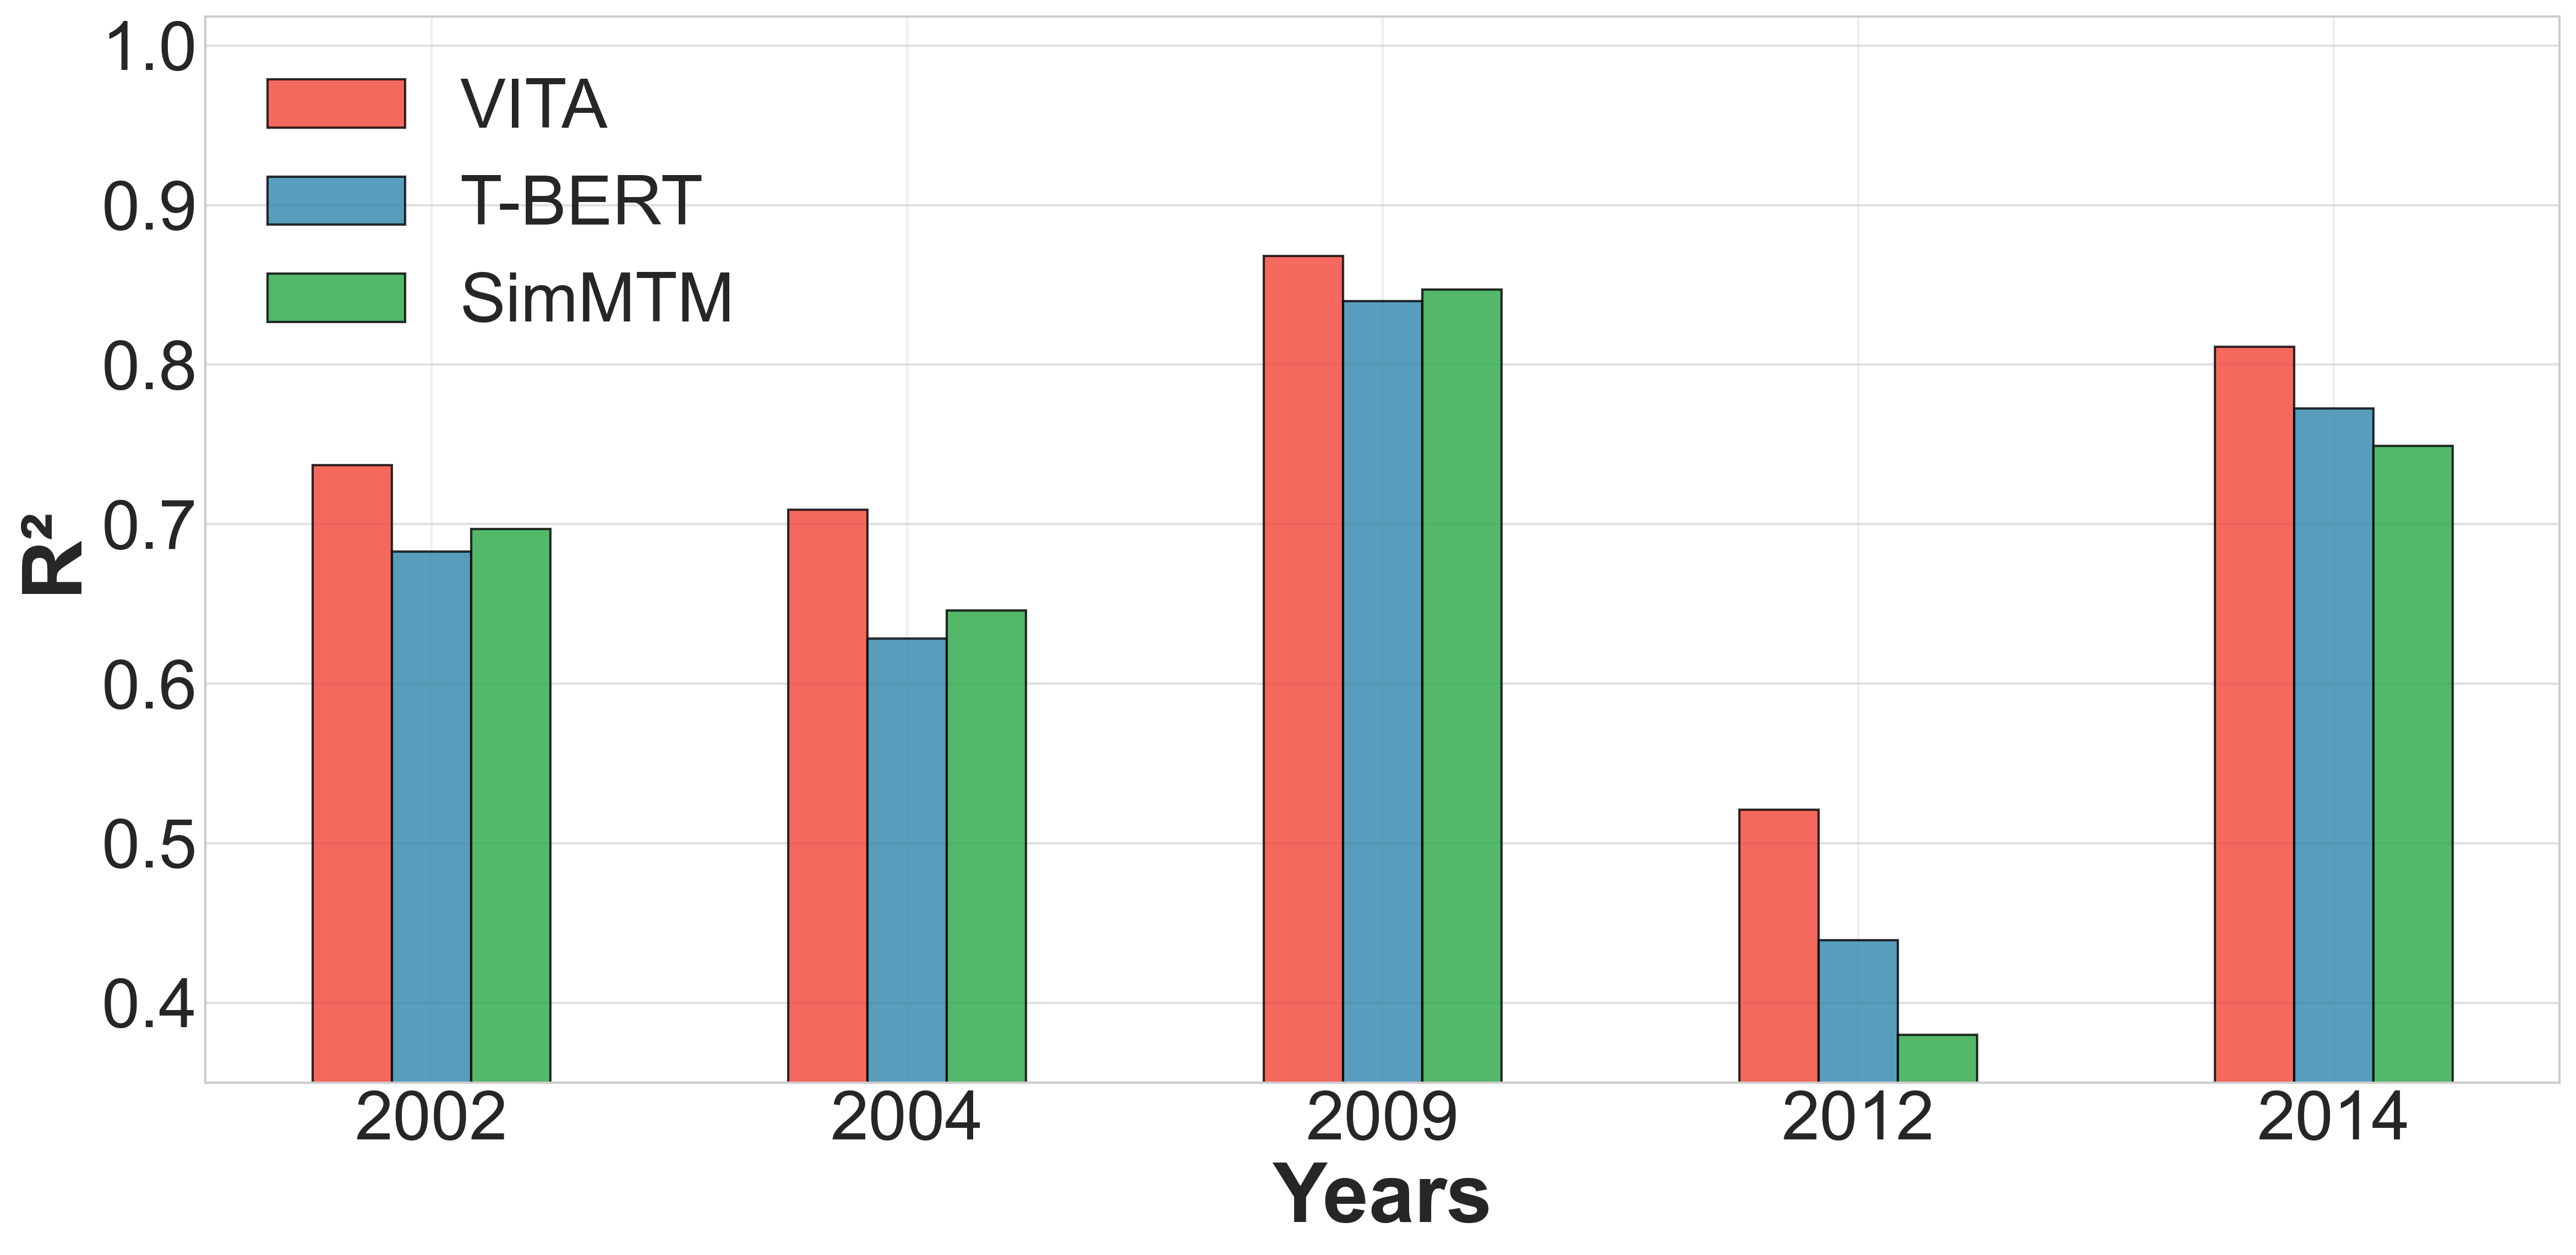

Bar plot saved as '../data/latex/img/individual_r2_comparison_corn.pdf'


In [262]:
# Create bar plot for individual R² values - neurips style
fig, ax = plt.subplots(figsize=(16, 8))

# Number of folds
n_folds = len(best_bert_individual_r2)
fold_labels = [str(year) for year in EXTREME_YEARS[crop_type]]

# Set up bar positions for 3 models - make groups closer together
x = np.arange(n_folds) * 0.6  # Multiply by 0.6 to bring year groups closer
width = 0.1

# Create bars using existing color palette - performance order: VITA, BERT, SimMTM
bars1 = ax.bar(x - width, best_weatherformer_individual_r2, width, 
               label=model_display_name, color=colors[model_display_name], alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, best_bert_individual_r2, width, 
               label='T-BERT', color=colors['BERT'], alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, best_simmtm_individual_r2, width, 
               label='SimMTM', color=colors['SimMTM'], alpha=0.8, edgecolor='black')

# Add numbers on top of bars - VITA, BERT, SimMTM
# for bar in bars1:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
#             f'{height:.2f}', ha='center', va='bottom', fontsize=22, fontweight='bold')

# for bar in bars2:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
#             f'{height:.2f}', ha='center', va='bottom', fontsize=22, fontweight='bold')

# for bar in bars3:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
#             f'{height:.2f}', ha='center', va='bottom', fontsize=22, fontweight='bold')

# Customize the plot - no title for neurips style
ax.set_xlabel('Years')
ax.set_ylabel('R²')
ax.set_xticks(x)
ax.set_xticklabels(fold_labels)
ax.legend()

# Set y-axis limits to better show the data
ax.set_ylim(0.35, max(max(best_weatherformer_individual_r2), max(best_bert_individual_r2), max(best_simmtm_individual_r2)) + 0.15)

# Add grid for better readability
ax.grid(True, alpha=0.6, axis='y')

plt.tight_layout()
plt.savefig(f'../data/latex/img/individual_r2_comparison_{crop_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Bar plot saved as '../data/latex/img/individual_r2_comparison_{crop_type}.pdf'")


In [263]:
# Compute mean and standard deviation of running time in minutes from JSON files
import numpy as np

def extract_runtime_minutes(json_data, batch_size=32):
    """Extract runtime minutes from JSON data, filtered by batch size for fairness"""
    runtimes = []
    for config_name, results in json_data.items():
        # Filter for specific batch size only for fair comparison
        if f'_bs_{batch_size}_' in config_name:
            if 'year_15' in results and 'runtime_seconds' in results['year_15']:
                runtime_minutes = results['year_15']['runtime_seconds'] / 60.0
                runtimes.append(runtime_minutes)
    return runtimes

def print_runtime_stats(runtimes, model_name, prefix="\n"):
    """Print runtime statistics for a given model"""
    if runtimes:
        mean = np.mean(runtimes)
        std = np.std(runtimes, ddof=1)  # sample standard deviation
        print(f"{prefix}{model_name}:")
        print(f"  Mean: {mean:.2f} minutes")
        print(f"  Std:  {std:.2f} minutes")
    else:
        print(f"{prefix}{model_name}: No runtime data found")

# Extract runtime data for each model
gnnrnn_runtimes = extract_runtime_minutes(gnnrnn_json)
bert_runtimes = extract_runtime_minutes(bert_json)
weatherformer_runtimes = extract_runtime_minutes(weatherformer_json)
simmtm_runtimes = extract_runtime_minutes(simmtm_json)

# Compute statistics
print("Running Time Statistics (in minutes):")
print("=" * 50)

print_runtime_stats(gnnrnn_runtimes, "GNN-RNN", prefix="")
print_runtime_stats(bert_runtimes, "BERT", prefix="")
print_runtime_stats(weatherformer_runtimes, model_display_name)
print_runtime_stats(simmtm_runtimes, "SimMTM")

# Overall statistics across all models
all_runtimes = gnnrnn_runtimes + bert_runtimes + weatherformer_runtimes + simmtm_runtimes
if all_runtimes:
    overall_mean = np.mean(all_runtimes)
    overall_std = np.std(all_runtimes, ddof=1)
    print(f"\nOverall (all models, batch size 32):")
    print(f"  Mean: {overall_mean:.2f} minutes")
    print(f"  Std:  {overall_std:.2f} minutes")
    print(f"  Total experiments: {len(all_runtimes)}")


Running Time Statistics (in minutes):
GNN-RNN:
  Mean: 7.13 minutes
  Std:  0.03 minutes
BERT:
  Mean: 23.65 minutes
  Std:  0.01 minutes

VITA:
  Mean: 24.67 minutes
  Std:  0.04 minutes

SimMTM:
  Mean: 23.64 minutes
  Std:  0.02 minutes

Overall (all models, batch size 32):
  Mean: 21.41 minutes
  Std:  6.59 minutes
  Total experiments: 18


In [277]:
import pandas as pd
from scipy.stats import ttest_ind

def evaluate_pretraining_effect(model_name, crop_type):
    """
    Evaluate the effect of pretraining on a given model.
    
    Args:
        model_name (str): Name of the model ('bert', 'weatherformersinusoid', 'simmtm', 'gnnrnn')
    
    Returns:
        dict: Statistics comparing pretrained vs not-pretrained performance
    """
    # Construct file paths based on model name and crop_type
    not_pretrained_path = f'data/grid_search_{model_name}_not_pretrained_{crop_type}.tsv'
    pretrained_path = f'data/grid_search_{model_name}_pretrained_{crop_type}.tsv'
    
    try:
        # Load data
        df_not_pretrained = pd.read_csv(not_pretrained_path, sep='\t')
        df_pretrained = pd.read_csv(pretrained_path, sep='\t')
        
        # Extract R^2 values using the same pattern as existing code
        r2_not_pretrained = df_not_pretrained['year_15_r2'].str.split(' ± ').str[0].astype(float)
        r2_pretrained = df_pretrained['year_15_r2'].str.split(' ± ').str[0].astype(float)
        
        # Compute statistics
        stats = {
            'model_name': model_name,
            'crop_type': crop_type,
            'not_pretrained': {
                'mean_r2': r2_not_pretrained.mean(),
                'std_r2': r2_not_pretrained.std(),
                'best_r2': r2_not_pretrained.max(),
                'n_experiments': len(r2_not_pretrained)
            },
            'pretrained': {
                'mean_r2': r2_pretrained.mean(),
                'std_r2': r2_pretrained.std(),
                'best_r2': r2_pretrained.max(),
                'n_experiments': len(r2_pretrained)
            }
        }
        
        # Perform t-test
        t_stat, p_val = ttest_ind(r2_pretrained, r2_not_pretrained, equal_var=False)
        stats['t_stat'] = t_stat
        stats['p_val'] = p_val
        
        # Calculate improvement
        stats['improvement'] = {
            'mean_diff': stats['pretrained']['mean_r2'] - stats['not_pretrained']['mean_r2'],
            'percent_improvement': ((stats['pretrained']['mean_r2'] - stats['not_pretrained']['mean_r2']) / stats['not_pretrained']['mean_r2']) * 100,
            'best_diff': stats['pretrained']['best_r2'] - stats['not_pretrained']['best_r2']
        }
        
        return stats
        
    except FileNotFoundError as e:
        print(f"Error: Could not find data files for model '{model_name}'")
        print(f"Expected files:")
        print(f"  - {not_pretrained_path}")
        print(f"  - {pretrained_path}")
        return None
    except Exception as e:
        print(f"Error processing data for model '{model_name}': {str(e)}")
        return None

# Example usage - test with one of the known models
for crop_type in ['soybean', 'corn']:
    print(f"Testing pretraining effect evaluation for {crop_type}...")
    print("=" * 50)
    test_result = evaluate_pretraining_effect('weatherformer', crop_type)
    if test_result:
        print(f"Model: {test_result['model_name']}")
        print(f"Crop: {test_result['crop_type']}")
        print(f"Not pretrained - Mean R²: {test_result['not_pretrained']['mean_r2']:.3f} ± {test_result['not_pretrained']['std_r2']:.3f}")
        print(f"Not pretrained - Best R²: {test_result['not_pretrained']['best_r2']:.3f}")
        print(f"Pretrained - Mean R²: {test_result['pretrained']['mean_r2']:.3f} ± {test_result['pretrained']['std_r2']:.3f}")
        print(f"Pretrained - Best R²: {test_result['pretrained']['best_r2']:.3f}")
        print(f"Mean Improvement: {test_result['improvement']['mean_diff']:.3f} ({test_result['improvement']['percent_improvement']:.1f}%)")
        print(f"Best Improvement: {test_result['improvement']['best_diff']:.3f}")
        print(f"T-test: t={test_result['t_stat']:.2f}, p={test_result['p_val']}")
        if test_result['p_val'] < 0.05:
            print("Statistical significance: p < 0.05 (significant)")
        else:
            print("Statistical significance: p ≥ 0.05 (not significant)")


Testing pretraining effect evaluation for soybean...
Model: weatherformer
Crop: soybean
Not pretrained - Mean R²: 0.638 ± 0.074
Not pretrained - Best R²: 0.714
Pretrained - Mean R²: 0.672 ± 0.025
Pretrained - Best R²: 0.715
Mean Improvement: 0.035 (5.5%)
Best Improvement: 0.001
T-test: t=2.33, p=0.0263424722863984
Statistical significance: p < 0.05 (significant)
Testing pretraining effect evaluation for corn...
Model: weatherformer
Crop: corn
Not pretrained - Mean R²: 0.574 ± 0.119
Not pretrained - Best R²: 0.685
Pretrained - Mean R²: 0.700 ± 0.020
Pretrained - Best R²: 0.734
Mean Improvement: 0.126 (22.0%)
Best Improvement: 0.049
T-test: t=5.44, p=8.934221369049271e-06
Statistical significance: p < 0.05 (significant)
